Differencing order 1: p-value = 0.70213
Series is stationary with 1 differencing (p-value: 0.00000)


c:\Users\hsingh\OneDrive - INVIDI Technologies Corp\machine learning\machine-learning\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\hsingh\OneDrive - INVIDI Technologies Corp\machine learning\machine-learning\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\hsingh\OneDrive - INVIDI Technologies Corp\machine learning\machine-learning\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the support

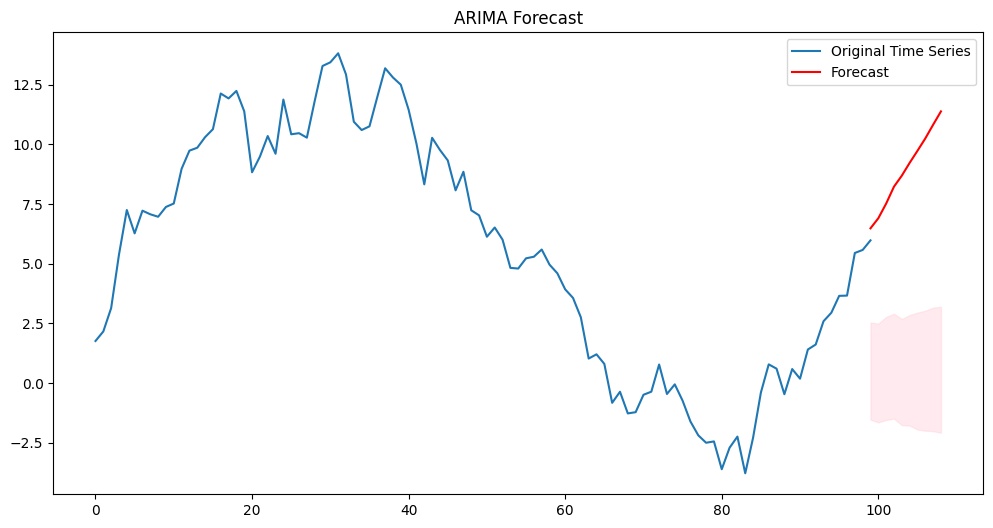

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -143.193
Date:                Tue, 08 Oct 2024   AIC                            298.385
Time:                        22:48:57   BIC                            313.895
Sample:                             0   HQIC                           304.659
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8123      0.098     -8.278      0.000      -1.005      -0.620
ar.L2         -0.5472      0.133     -4.106      0.000      -0.808      -0.286
ar.L3         -0.4493      0.114     -3.931      0.0

In [3]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

def adf_test(time_series, significance_level=0.05):
    """
    Perform the Augmented Dickey-Fuller test to check stationarity.

    Parameters:
    - time_series: The time series data as a pandas Series.
    - significance_level: The significance level for the ADF test.

    Returns:
    - stationary: Boolean indicating if the series is stationary.
    - p_value: The p-value from the ADF test.
    """
    adf_result = adfuller(time_series)
    p_value = adf_result[1]
    stationary = p_value < significance_level
    return stationary, p_value

def make_stationary(time_series, max_diff=5):
    """
    Make the time series stationary by differencing.

    Parameters:
    - time_series: The time series data as a pandas Series.
    - max_diff: Maximum number of differences to attempt.

    Returns:
    - stationary_series: The differenced series.
    - diff_order: The order of differencing applied.
    """
    diff_order = 0
    stationary_series = time_series.copy()
    
    while diff_order < max_diff:
        stationary, p_value = adf_test(stationary_series)
        if stationary:
            print(f"Series is stationary with {diff_order} differencing (p-value: {p_value:.5f})")
            break
        stationary_series = stationary_series.diff().dropna()
        diff_order += 1
        print(f"Differencing order {diff_order}: p-value = {p_value:.5f}")
    
    if diff_order == max_diff:
        print("Warning: Series is still not stationary after maximum differencing attempts.")
    
    return stationary_series, diff_order

def fit_arima_model(time_series, order=(1, 1, 1), forecast_steps=10):
    """
    Fit an ARIMA model to a time series and make predictions.

    Parameters:
    - time_series: The time series data as a pandas Series.
    - order: The (p, d, q) order of the ARIMA model.
    - forecast_steps: Number of steps ahead to forecast.

    Returns:
    - fitted_model: The fitted ARIMA model.
    - forecast: Forecasted values for the specified number of steps.
    - confidence_intervals: 95% confidence intervals for the forecast.
    """
    model = ARIMA(time_series, order=order)
    fitted_model = model.fit()

    # Make forecast
    forecast = fitted_model.forecast(steps=forecast_steps)
    conf_int = fitted_model.get_forecast(steps=forecast_steps).conf_int()

    return fitted_model, forecast, conf_int

def invert_differencing(original_series, differenced_forecast, diff_order):
    """
    Invert differencing to get forecast values on the original scale.

    Parameters:
    - original_series: The original time series before differencing.
    - differenced_forecast: Forecasted values for the differenced series.
    - diff_order: The order of differencing applied.

    Returns:
    - forecast_on_original_scale: Forecast values on the original time series scale.
    """
    forecast_on_original_scale = differenced_forecast.copy()
    for i in range(diff_order):
        forecast_on_original_scale = forecast_on_original_scale.cumsum() + original_series.iloc[-1]
    
    return forecast_on_original_scale

def plot_forecast(time_series, forecast, conf_int):
    """
    Plot the original time series and the forecast with confidence intervals.

    Parameters:
    - time_series: The original time series as a pandas Series.
    - forecast: The forecasted values.
    - conf_int: 95% confidence intervals for the forecast.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(time_series, label='Original Time Series')
    plt.plot(forecast, label='Forecast', color='red')

    # Plot confidence intervals
    plt.fill_between(forecast.index, 
                     conf_int.iloc[:, 0], 
                     conf_int.iloc[:, 1], 
                     color='pink', alpha=0.3)

    plt.title('ARIMA Forecast')
    plt.legend()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load your time series data into a pandas Series
    np.random.seed(0)
    time_series_data = pd.Series(np.random.randn(100).cumsum())

    # Make the series stationary if required
    stationary_series, diff_order = make_stationary(time_series_data)

    # Fit ARIMA model
    fitted_model, forecast, conf_int = fit_arima_model(stationary_series, order=(5, 1, 0), forecast_steps=10)

    # Invert differencing to get the forecast on the original scale
    forecast_original_scale = invert_differencing(time_series_data, forecast, diff_order)

    # Plot the forecast
    plot_forecast(time_series_data, forecast_original_scale, conf_int)

    # Print model summary
    print(fitted_model.summary())
